In [ ]:
!pip install d2l==0.16.

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [5]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive
!ls
%cd d2l-dataset/

Mounted at /content/drive
/content/drive/My Drive
'Colab Notebooks'   d2l-dataset   d2l-zh   data   test.ipynb
/content/drive/My Drive/d2l-dataset


In [10]:
import torchvision
from torch.utils import data
from torchvision import transforms
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
 # 注意：colab只支持2线程，所以这里的num_works为2
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))


In [11]:
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

In [12]:
#返回当前设备索引
torch.cuda.current_device()
#返回GPU的数量
torch.cuda.device_count()
#返回gpu名字，设备索引默认从0开始
torch.cuda.get_device_name(0)
#cuda是否可用
torch.cuda.is_available()


True

loss 0.178, train acc 0.934, test acc 0.919
762.8 examples/sec on cuda:0


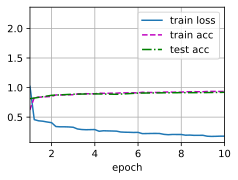

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())